In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from utils import *

np.random.seed(0)

In [ ]:
def make_datasets(size=1500) :
    X, Y = datasets.make_moons(n_samples=size, noise=.05)
    
    data = torch.from_numpy(X).float()
    label = torch.from_numpy(Y)
    
    return data, label

def rotate_around_point_highperf(data, degree, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """
    
    radians = math.radians(degree)
    x, y = data[:,0], data[:,1]
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    data[:,0] = qx
    data[:,1] = qy
    
    return data

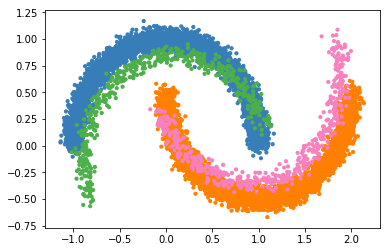

In [2]:
X_train, Y_train = make_datasets(10000)
train_data = TensorDataset(X_train, Y_train)

X_test, Y_test = make_datasets(1000)
X_test = rotate_around_point_highperf(X_test, degree=-20, origin=(0.5, 0.25))
show_data(torch.cat([X_train, X_test], dim=0).numpy(), torch.cat([Y_train, Y_test+2], dim=0).numpy())
test_data = TensorDataset(X_test, Y_test)

batch_size = 100

train_loader = DataLoader(batch_size=batch_size, dataset=train_data, shuffle=True)
test_loader = DataLoader(batch_size=batch_size, dataset=test_data, shuffle=False)

In [3]:
model = nn.Sequential(
    nn.Linear(2, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1),
    nn.Sigmoid()
).cuda()

In [4]:
loss = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

model.train()
    
for i, (batch_data, batch_labels) in enumerate(train_loader):

    X = batch_data.cuda()
    Y = batch_labels.cuda()

    pre = model(X).squeeze()
    cost_a = loss(pre, Y.float())

    model_sub = nn.Sequential(*model[:4])
    features_source = model_sub(X)

    mean_1 = features_source[torch.masked_select(torch.arange(len(Y)), Y.cpu().bool()), :].mean(dim=0)
    mean_2 = features_source[torch.masked_select(torch.arange(len(Y)), (1-Y.cpu()).bool()), :].mean(dim=0)
    mu = torch.stack([mean_1, mean_2])

    features_target = model_sub(X_test[torch.randperm(len(X_test))[:len(Y)]].cuda())
    cost_b = DADEC(features_source, features_target, mu, n=3, alpha=-1)

    cost = cost_a #+ cost_b

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Iter [%d/%d], Loss A: %.4f, Loss B: %.4f'%(i+1, len(train_loader), cost_a.item(), cost_b.item()))

print("Learning Finished!")

Iter [1/100], Loss A: 0.6917, Loss B: 0.1026
Iter [2/100], Loss A: 0.5443, Loss B: 0.1372
Iter [3/100], Loss A: 0.4475, Loss B: 0.1185
Iter [4/100], Loss A: 0.3881, Loss B: 0.1370
Iter [5/100], Loss A: 0.3076, Loss B: 0.1783
Iter [6/100], Loss A: 0.3016, Loss B: 0.1693
Iter [7/100], Loss A: 0.2771, Loss B: 0.1683
Iter [8/100], Loss A: 0.2906, Loss B: 0.1745
Iter [9/100], Loss A: 0.1804, Loss B: 0.1925
Iter [10/100], Loss A: 0.2363, Loss B: 0.1417
Iter [11/100], Loss A: 0.2803, Loss B: 0.1402
Iter [12/100], Loss A: 0.2429, Loss B: 0.1461
Iter [13/100], Loss A: 0.2925, Loss B: 0.1598
Iter [14/100], Loss A: 0.1849, Loss B: 0.1705
Iter [15/100], Loss A: 0.1584, Loss B: 0.1665
Iter [16/100], Loss A: 0.2248, Loss B: 0.1632
Iter [17/100], Loss A: 0.1778, Loss B: 0.1934
Iter [18/100], Loss A: 0.2630, Loss B: 0.1883
Iter [19/100], Loss A: 0.1306, Loss B: 0.1934
Iter [20/100], Loss A: 0.1246, Loss B: 0.1944
Iter [21/100], Loss A: 0.0905, Loss B: 0.1948
Iter [22/100], Loss A: 0.0760, Loss B: 0.16

In [5]:
model.cpu(), X_test.cpu(), Y_test.cpu()
print("CPU")

CPU


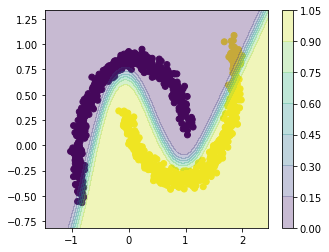

In [6]:
decision_boundary(model, X_test, Y_test, 300, 0.3)

In [7]:
get_acc(model, test_loader)

94.6

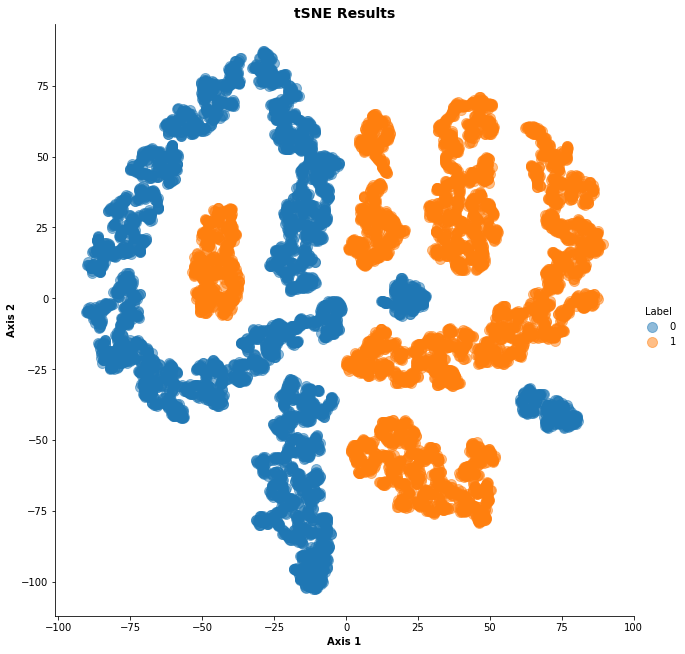

In [8]:
show_TSNE(nn.Sequential(*model[:4]), X_train, Y_train)

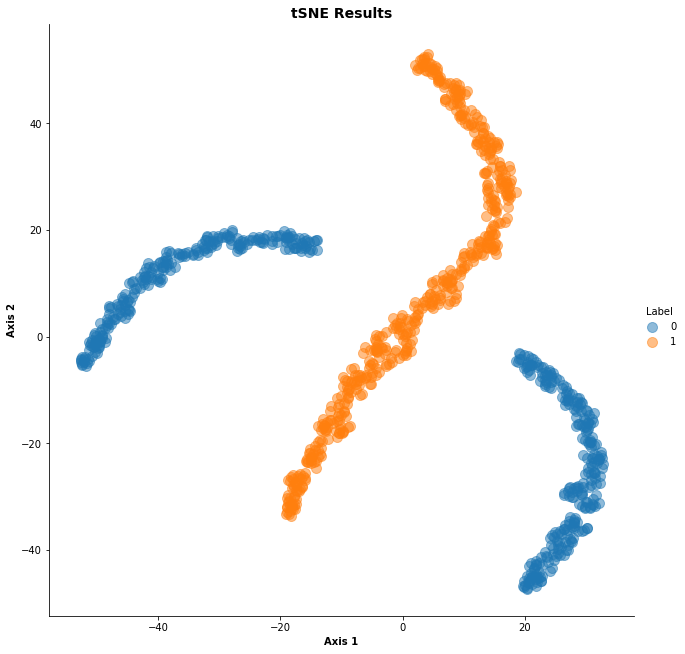

In [9]:
show_TSNE(nn.Sequential(*model[:4]), X_test, Y_test)